#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the plotting and viewing of different results:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [6]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from itertools import product
from IPython.display import display, HTML

In [7]:
def smart_fmt_single_setting(x):
    if x is None:
        return "--"
    try:
        return f"{float(x):.3e}"
    except (ValueError, TypeError):
        return "--"


def metrics_summary_single_setting(metric_dict, metrics, methods, settings):
    """
    Build a compact summary for the single-setting case.

    Returns: dict keyed as "{metric}_{method}_{setting_value}" -> [mean, min, max]
    Example key: "mse_beta_TAVIE_1000"
    """
    if len(settings) != 1:
        raise ValueError("metrics_summary_single_setting expects exactly one setting.")
    sval = settings[0]

    res = {}
    for metric, method in product(metrics, methods):
        dict_key = f"{metric}_{method}"
        # For single setting, metric_dict[dict_key] should be an array-like of repetitions
        arr = np.asarray(metric_dict[dict_key], dtype=float).ravel()
        mu, mn, mx = np.nanmedian(arr), np.nanpercentile(arr, 25), np.nanpercentile(arr, 75)
        res[f"{metric}_{method}_{sval}"] = [mu, mn, mx]
    return res

# ---------- HTML table (rows = methods, cols = metrics) ----------
def build_html_table_single_setting(summary,
                                    metrics, metric_display,
                                    methods, method_display):
    """
    Returns a DataFrame whose index = method display names and columns = metric display names.
    Each cell contains HTML with mean on top and (min, max) below.
    """
    # Infer the single setting value from any key in the summary
    if not summary:
        raise ValueError("Empty summary passed to build_html_table_single_setting.")
    # Pull one key and parse the trailing setting token
    example_key = next(iter(summary))
    sval = example_key.split("_")[-1]

    rows = []
    for meth_id, meth_disp in zip(methods, method_display):
        cell_vals = {}
        for met_id, met_disp in zip(metrics, metric_display):
            key = f"{met_id}_{meth_id}_{sval}"
            if key in summary:
                mu, mn, mx = summary[key]
                cell_vals[met_disp] = (
                    f"{smart_fmt_single_setting(mu)}"
                    f"<br>({smart_fmt_single_setting(mn)}, {smart_fmt_single_setting(mx)})"
                )
            else:
                cell_vals[met_disp] = "--"
        rows.append((meth_disp, cell_vals))

    df = pd.DataFrame.from_dict(dict(rows), orient="index")
    df.index.name = "Methods"
    # Nice HTML display (line breaks inside cells)
    display(HTML(df.to_html(escape=False)))
    return df  # also return the DataFrame if you need to style further


def to_latex_single_setting(summary,
                            metrics, metric_display,
                            methods, method_display,
                            caption=None, label="tab:single-setting",
                            fontsize="\\small", arraystretch=1.1):
    """
    Longtable where:
      - Column 1: Methods
      - Columns 2..K: metrics (each cell shows mean with min/max beneath via \\makecell)
    Required LaTeX packages: longtable, booktabs, makecell
    """
    if not summary:
        raise ValueError("Empty summary passed to to_latex_single_setting.")

    # Column spec: one left col for methods, then centered metric columns
    k = len(metrics)
    colspec = "l" + "c" * k

    if caption is None:
        caption = "Results by method."

    # Header rows
    head_top = []
    head_top.append("\\toprule")
    metric_head = " & ".join(metric_display)
    head_top.append(f"Methods & {metric_head} \\\\")
    head_top.append("\\midrule")
    head_repeat = head_top.copy()

    # Footer rows
    foot_mid = ["\\midrule",
                f"\\multicolumn{{{1+k}}}{{r}}{{Continued on next page}} \\\\",
                "\\midrule"]
    foot_last = ["\\bottomrule"]

    # Build table lines
    lines = []
    lines.append("% Required packages: \\usepackage{longtable,booktabs,makecell}")
    if fontsize:
        lines.append(f"{{{fontsize}")
    lines.append(f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}%")
    lines.append(f"\\begin{{longtable}}{{{colspec}}}")
    lines.append(f"\\caption{{{caption}}} \\label{{{label}}} \\\\")
    lines.extend(head_top)
    lines.append("\\endfirsthead")
    lines.extend(head_repeat)
    lines.append("\\endhead")
    lines.extend(foot_mid)
    lines.append("\\endfoot")
    lines.extend(foot_last)
    lines.append("\\endlastfoot")

    # Get the single setting value from any key
    sval = next(iter(summary)).split("_")[-1]

    # Body: each row = method, cells = metrics
    for meth_id, meth_disp in zip(methods, method_display):
        cells = []
        for met_id in metrics:
            key = f"{met_id}_{meth_id}_{sval}"
            if key in summary:
                mu, mn, mx = summary[key]
                cells.append(
                    f"\\makecell[c]{{{smart_fmt_single_setting(mu)}\\\\"
                    f"({smart_fmt_single_setting(mn)}, {smart_fmt_single_setting(mx)})}}"
                )
            else:
                cells.append("--")
        lines.append(meth_disp + " & " + " & ".join(cells) + " \\\\")

    lines.append("\\end{longtable}")
    if fontsize:
        lines.append("}")

    return "\n".join(lines)


### Code for getting nice tables for paper in multi n single p and single n multi p cases

In [8]:
def smart_fmt(x):
    if x is None:
        return "--"
    try:
        return f"{float(x):.3e}"
    except (ValueError, TypeError):
        return "--"


def metrics_summary(metric_dict, metrics, methods, settings):
    """Build dict {metric_method_setting: [mean, min, max]} from raw metric_dict."""
    setting_no = range(len(settings))
    res_dict = {}
    for metric, method, setting in product(metrics, methods, setting_no):
        dict_key = f"{metric}_{method}"
        if len(settings) == 1:
            temp = metric_dict[dict_key]
        else:
            temp = metric_dict[dict_key][setting]
            arr = np.asarray(temp, dtype=float).ravel()
            mu, mn, mx = np.nanmedian(arr), np.nanpercentile(arr, 25), np.nanpercentile(arr, 75)
        res_dict[f"{metric}_{method}_{settings[setting]}"] = [mu, mn, mx]
    return res_dict

# ---------- Simple HTML display table (unchanged) ----------
def build_tables_from_summary(summary, metrics, metric_display, methods, method_display,
                              settings, settings_name="n", for_latex=False):
    rows = []
    for metric, metric_disp in zip(metrics, metric_display):
        for method, method_disp in zip(methods, method_display):
            cell_vals = {}
            for n in settings:
                key = f"{metric}_{method}_{n}"
                if key in summary:
                    mu, mn, mx = summary[key]
                    if for_latex:
                        # we'll ignore this for LaTeX now (we generate LaTeX manually)
                        cell_vals[n] = f"{smart_fmt(mu)}\\\\({smart_fmt(mn)}, {smart_fmt(mx)})"
                    else:
                        cell_vals[n] = f"{smart_fmt(mu)}<br>({smart_fmt(mn)}, {smart_fmt(mx)})"
                else:
                    cell_vals[n] = "--"
            rows.append(((metric_disp, method_disp), cell_vals))
    df = pd.DataFrame.from_dict(dict(rows), orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Metric", "Method"])
    df = df[settings]  # enforce column order
    df.columns.name = settings_name
    display(HTML(df.to_html(escape=False)))
    return df

# ---------- CLEAN LaTeX generator (manual; tidy) ----------
def to_latex_from_summary_clean(summary,
                                metrics, metric_display,
                                methods, method_display,
                                settings, settings_name="n",
                                caption=None, label="tab:mean-range",
                                fontsize="\\small", arraystretch=1.15):
    """
    Generates a clean longtable:
      - First column: Metric (multirow over methods)
      - Second column: Method
      - Remaining columns: settings values
      - Each data cell uses \\makecell[r]{mean\\(min, max)} for stacked lines
    Requires LaTeX packages: longtable, booktabs, multirow, makecell
    """
    k = len(settings)
    # Column format: Metric (l), Method (l), then k right-aligned numeric columns
    colspec = "ll" + "c" * k

    # Caption default
    if caption is None:
        n_list = ", ".join(map(str, settings))
        caption = rf"Mean and range across repetitions; columns are {settings_name} $\in\{{{n_list}\}}$."

    # Header (appears at table top and on continued pages)
    head_top = []
    head_top.append("\\toprule")
    # First header row: blank over Metric/Method headers then the settings values
    settings_head = " & ".join(str(s) for s in settings)
    head_top.append(f" &  & \\multicolumn{{{k}}}{{c}}{{{settings_name}}} \\\\")
    head_top.append("\\cmidrule(lr){" + f"3-{2+k}" + "}")
    head_top.append(f"Metric & Method & {settings_head} \\\\")
    head_top.append("\\midrule")

    head_repeat = head_top.copy()
    head_repeat[0] = "\\toprule"  # same styling on new pages

    # Footer on continued pages
    foot_mid = ["\\midrule",
                f"\\multicolumn{{{2+k}}}{{r}}{{Continued on next page}} \\\\",
                "\\midrule"]
    foot_last = ["\\bottomrule"]

    # Begin building table
    lines = []
    lines.append("% Required packages: \\usepackage{longtable,booktabs,multirow,makecell}")
    if fontsize:
        lines.append(f"{{{fontsize}")
    lines.append(f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}%")
    lines.append(f"\\begin{{longtable}}{{{colspec}}}")
    lines.append(f"\\caption{{{caption}}} \\label{{{label}}}\\\\")
    lines.extend(head_top)
    lines.append("\\endfirsthead")
    lines.extend(head_repeat)
    lines.append("\\endhead")
    lines.extend(foot_mid)
    lines.append("\\endfoot")
    lines.extend(foot_last)
    lines.append("\\endlastfoot")

    # Body: for each metric group, multirow across the number of methods
    for m_disp, m_id in zip(metric_display, metrics):
        group_rows = []
        for meth_disp, meth_id in zip(method_display, methods):
            cells = []
            for n in settings:
                key = f"{m_id}_{meth_id}_{n}"
                if key in summary:
                    mu, mn, mx = summary[key]
                    cells.append(f"\\makecell[c]{{{smart_fmt(mu)}\\\\({smart_fmt(mn)}, {smart_fmt(mx)})}}")
                else:
                    cells.append("--")
            group_rows.append((meth_disp, cells))

        # Write first row with \multirow{len(methods)}{*}{Metric}
        first_meth, first_cells = group_rows[0]
        lines.append(f"\\multirow{{{len(group_rows)}}}{{*}}{{{m_disp}}} & {first_meth} & " +
                     " & ".join(first_cells) + " \\\\")
        # Remaining methods in the group
        for meth_disp, cells in group_rows[1:]:
            lines.append(f" & {meth_disp} & " + " & ".join(cells) + " \\\\")
        # Add a little breathing room between groups
        lines.append("\\hline")

    lines.append("\\end{longtable}")
    if fontsize:
        lines.append("}")  # close font size group

    latex_code = "\n".join(lines)
    return latex_code

## Reading the results for Laplace and plotting

### Laplace SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=[200,500,1000,2000]; p=5)

In [94]:
p = 8  # <-- set this to whatever you used
path2 = f"results_compete/Laplace_metrics_multi_n_p_{p}.pkl"

metrics_df_2 = pd.read_pickle(path2)
sample_sizes = metrics_df_2['n']

mse_beta_TAVIE = metrics_df_2['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_2['mse_tau2_TAVIE']
time_TAVIE = metrics_df_2['time_TAVIE']

mse_beta_DADVI = metrics_df_2['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_2['mse_tau2_DADVI']
time_DADVI = metrics_df_2['time_DADVI']

mse_beta_ADVI_mf = metrics_df_2['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_2['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_2['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_2['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_2['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_2['time_ADVI_fr']

mse_beta_NUTS = metrics_df_2['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_2['mse_tau2_NUTS']
time_NUTS = metrics_df_2['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [82]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_2
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [200, 500, 1000, 2000]
settings_name = "Sample Size"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Laplace SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccc}
\caption{Average metrics (mean over repetitions; range below) for Laplace SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{4}{c}{Sample Size} \\
\cmidrule(lr){3-6}
Metric & Method & 200 & 500 & 1000 & 2000 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{4}{c}{Sample Size} \\
\cmidrule(lr){3-6}
Metric & Method & 200 & 500 & 1000 & 2000 \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{5}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{1.942e-03\\(1.271e-03, 2.808e-03)} & \makecell[c]{6.709e-04\\(4.707e-04, 9.619e-04)} & \makecell[c]{3.472e-04\\(2.313e-04, 4.866e-04)} & \makecell[c]{1.640e-04\\(1.200e-04, 2.333e-04)} \\
 & DADVI & \makecell[c]{2.156e-03\\(1.344e-03, 2.925e-03)} & \makecell[c]{7.294e-04\\(5.107e-04, 9.775e-04)} & \makecell[c]{3.539e-04\\(2.4

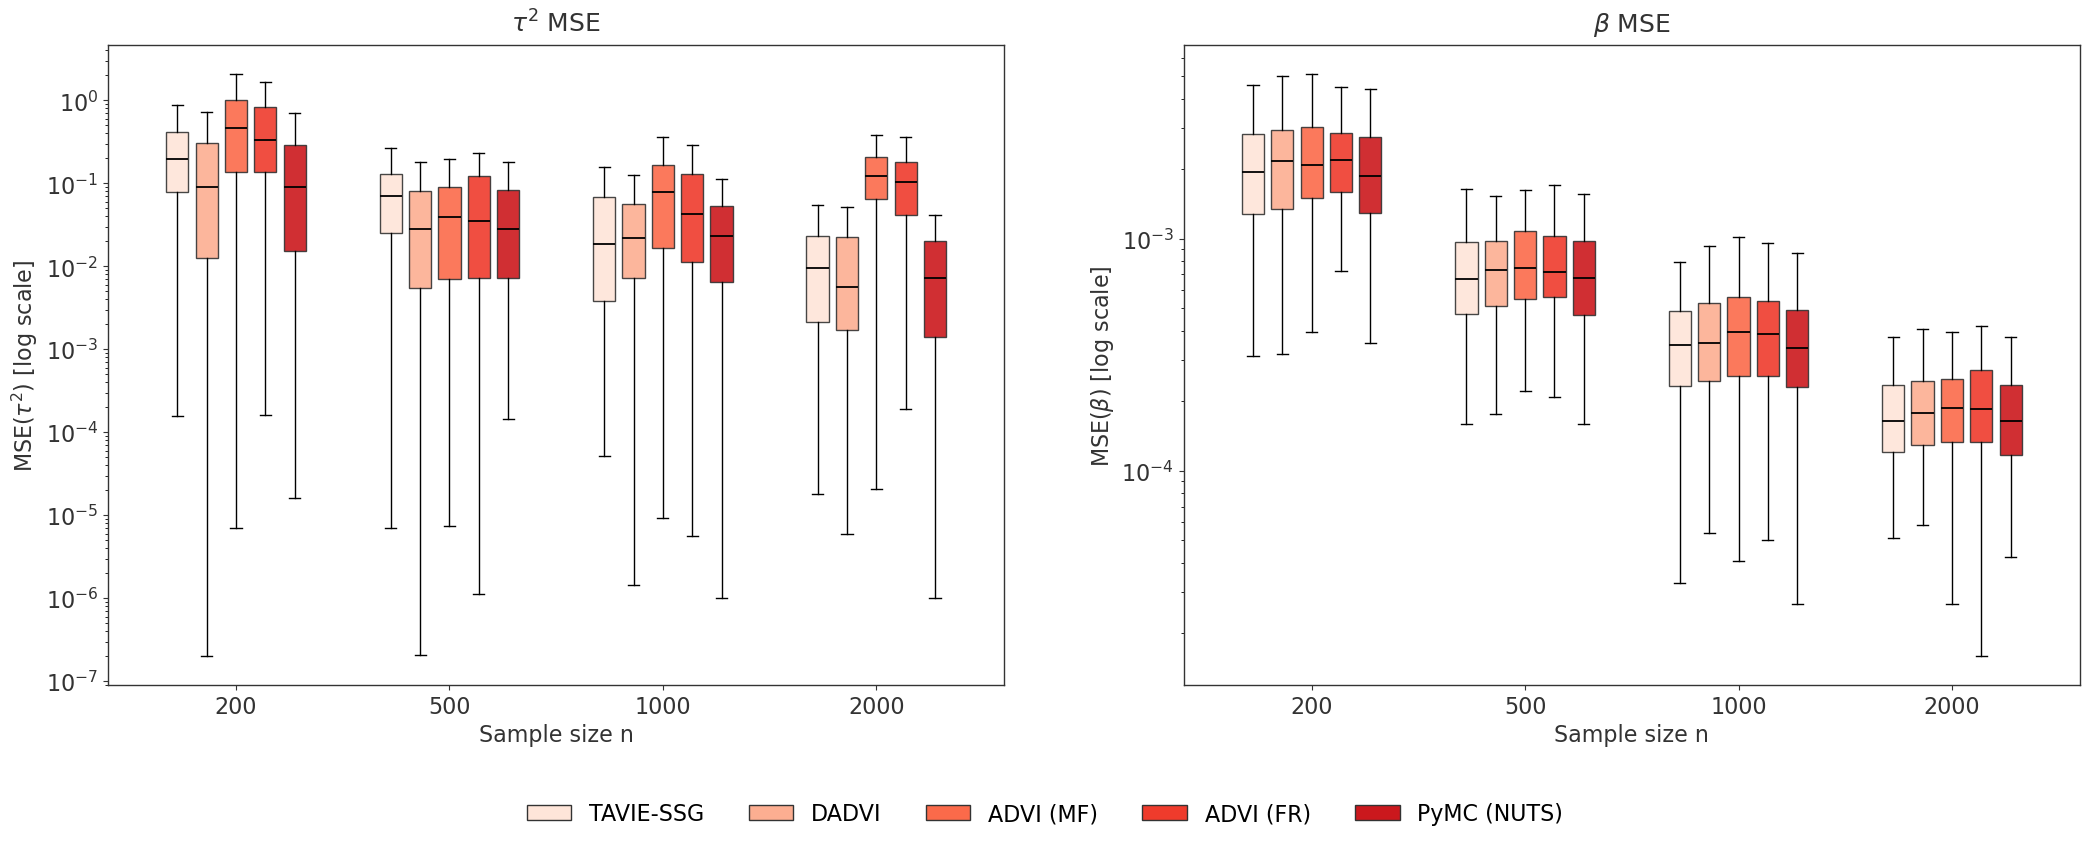

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

methods  = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# nicer palette (see below for more options)
#colors   = ['#355C7D', '#F67280', '#99B898', '#C06C84', '#F8B195', '#6C5B7B']
# colors = [
#     '#fde0dd',  # light rose
#     '#fcbba1',  # salmon pink
#     '#fc9272',  # soft coral
#     '#fb6a4a',  # reddish coral
#     '#de2d26',  # crimson red
#     '#a50f15'   # deep maroon
# ]
colors = [
    '#fee5d9',  # light rose
    '#fcae91',  # warm peach
    '#fb6a4a',  # vivid coral
    '#ef3b2c',  # bright scarlet
    '#cb181d',  # deep red
    '#a01520'   # balanced crimson (less maroon, cleaner finish)
]


n_sizes  = len(sample_sizes)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between n-groups on the x-axis
method_step   = 0.33    # separation between methods within each group
box_width     = 0.25    # visual width of each box
centers       = np.arange(n_sizes) * group_spacing  # group centers for each n

fig, axes = plt.subplots(1, 2, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# global style for axes
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='#333333', labelsize=16)
    #ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- 1) τ² MSE (log scale) ----------
ax = axes[0]
tau2_arrays = [
    mse_tau2_TAVIE,
    mse_tau2_DADVI,
    mse_tau2_ADVI_mf,
    mse_tau2_ADVI_fr,
    mse_tau2_NUTS,
]

for j, arr in enumerate(tau2_arrays):
    # data for each n: arr[i, :] is the vector of replications
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,           # often cleaner on log-scale
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\tau^2$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- 2) β MSE (log scale) ----------
ax = axes[1]
beta_arrays = [
    mse_beta_TAVIE,
    mse_beta_DADVI,
    mse_beta_ADVI_mf,
    mse_beta_ADVI_fr,
    mse_beta_NUTS,
]

for j, arr in enumerate(beta_arrays):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])

plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)
fig.savefig(
    f'results_compete/plots/Laplace_MSE_boxplots_multi_n_p_{p}.png',  # choose your preferred path/name
    dpi=300,
    bbox_inches='tight',   # ensures no clipping of labels/legend
    facecolor='white'      # preserves clean white background
)
plt.show()

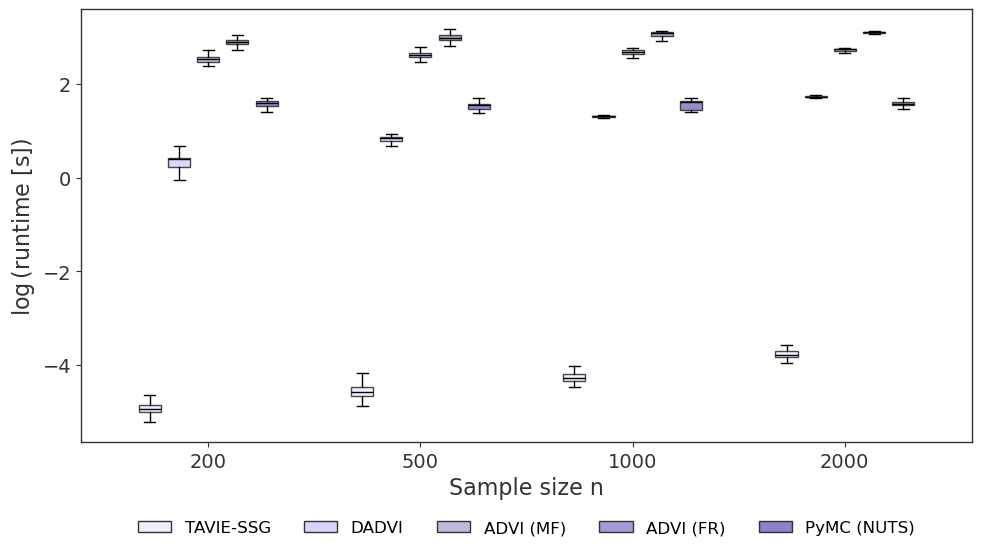

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# 6-step lavender–purple gradient centered on #BEBADA
colors_runtime = [
    '#f2ecff',  # very light lilac
    '#ddd1ff',  # soft lavender
    '#bebada',  # pastel purple (anchor tone)
    '#a89ad6',  # deeper lavender
    '#8f7ec9',  # bluish purple
    '#715fb3',  # dark violet
]

# colors_runtime = [
#     '#fee5d9',  # light rose
#     '#fcae91',  # warm peach
#     '#fb6a4a',  # vivid coral
#     '#ef3b2c',  # bright scarlet
#     '#cb181d',  # deep red
#     '#a01520'   # balanced crimson (less maroon, cleaner finish)
# ]

runtime_arrays_n = [
    time_TAVIE, time_DADVI,
    time_ADVI_mf, time_ADVI_fr, time_NUTS
]

n_sizes = len(sample_sizes)
M = len(methods)
group_spacing = 2.4
method_step = 0.33
box_width = 0.25
centers = np.arange(n_sizes) * group_spacing

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.0)

# ----- Boxplots only -----
for j, arr in enumerate(runtime_arrays_n):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )

    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

# ----- Axes styling -----
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=14)
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=16, color='#333333')
#ax.set_title('Log-runtime by method', fontsize=16, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
#ax.grid(True, linestyle='--', color='#BBBBBB', alpha=0.6)

# ----- Legend -----
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
ax.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
          fontsize=12, bbox_to_anchor=(0.5, -0.25))

plt.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig('results_compete/plots/runtime_logscale_lavender_boxplotonly.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


### Laplace SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000; p=[3,4,5,6])

In [96]:
n = 1000
path3 = f'results_compete/Laplace_metrics_multi_p_n_{n}.pkl'

metrics_df_3 = pd.read_pickle(path3)
p_values = metrics_df_3['p']

mse_beta_TAVIE = metrics_df_3['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_3['mse_tau2_TAVIE']
time_TAVIE = metrics_df_3['time_TAVIE']

mse_beta_DADVI = metrics_df_3['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_3['mse_tau2_DADVI']
time_DADVI = metrics_df_3['time_DADVI']

mse_beta_ADVI_mf = metrics_df_3['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_3['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_3['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_3['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_3['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_3['time_ADVI_fr']

mse_beta_NUTS = metrics_df_3['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_3['mse_tau2_NUTS']
time_NUTS = metrics_df_3['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [87]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_3
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [3, 8, 15, 20]
settings_name = "Dimension (p)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Laplace SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccc}
\caption{Average metrics (mean over repetitions; range below) for Laplace SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{4}{c}{Dimension (p)} \\
\cmidrule(lr){3-6}
Metric & Method & 3 & 8 & 15 & 20 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{4}{c}{Dimension (p)} \\
\cmidrule(lr){3-6}
Metric & Method & 3 & 8 & 15 & 20 \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{5}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{2.876e-04\\(1.925e-04, 5.205e-04)} & \makecell[c]{3.603e-04\\(2.418e-04, 4.938e-04)} & \makecell[c]{3.699e-04\\(2.886e-04, 4.899e-04)} & \makecell[c]{3.998e-04\\(3.148e-04, 5.113e-04)} \\
 & DADVI & \makecell[c]{3.018e-04\\(1.983e-04, 5.484e-04)} & \makecell[c]{3.521e-04\\(2.459e-04, 5.364e-04)} & \makecell[c]{3.679e-04\\(2.986e-04, 4.70

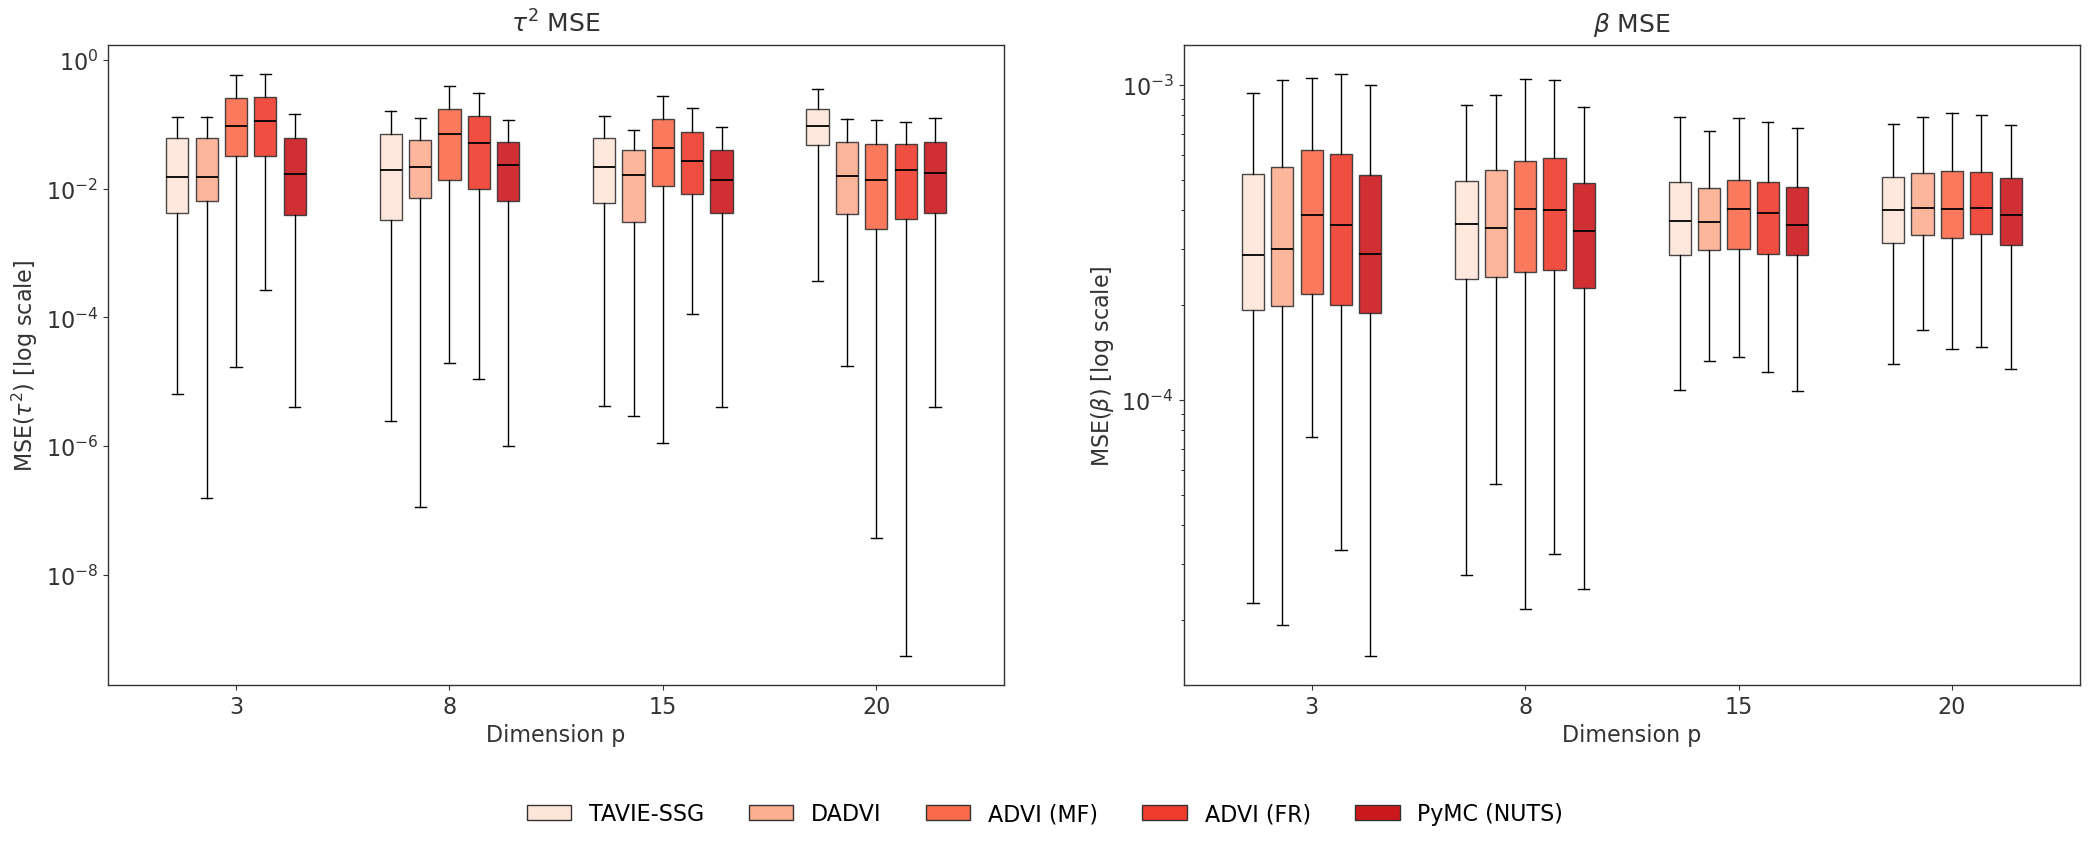

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

methods  = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# nicer palette (see below for more options)
#colors   = ['#355C7D', '#F67280', '#99B898', '#C06C84', '#F8B195', '#6C5B7B']
# colors = [
#     '#fde0dd',  # light rose
#     '#fcbba1',  # salmon pink
#     '#fc9272',  # soft coral
#     '#fb6a4a',  # reddish coral
#     '#de2d26',  # crimson red
#     '#a50f15'   # deep maroon
# ]
colors = [
    '#fee5d9',  # light rose
    '#fcae91',  # warm peach
    '#fb6a4a',  # vivid coral
    '#ef3b2c',  # bright scarlet
    '#cb181d',  # deep red
    '#a01520'   # balanced crimson (less maroon, cleaner finish)
]




p_sizes  = len(p_values)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between n-groups on the x-axis
method_step   = 0.33    # separation between methods within each group
box_width     = 0.25    # visual width of each box
centers       = np.arange(p_sizes) * group_spacing  # group centers for each n

fig, axes = plt.subplots(1, 2, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# global style for axes
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='#333333', labelsize=16)
    #ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- 1) τ² MSE (log scale) ----------
ax = axes[0]
tau2_arrays = [
    mse_tau2_TAVIE,
    mse_tau2_DADVI,
    mse_tau2_ADVI_mf,
    mse_tau2_ADVI_fr,
    mse_tau2_NUTS,
]

for j, arr in enumerate(tau2_arrays):
    # data for each n: arr[i, :] is the vector of replications
    data = [arr[i, :] for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,           # often cleaner on log-scale
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\tau^2$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- 2) β MSE (log scale) ----------
ax = axes[1]
beta_arrays = [
    mse_beta_TAVIE,
    mse_beta_DADVI,
    mse_beta_ADVI_mf,
    mse_beta_ADVI_fr,
    mse_beta_NUTS,
]

for j, arr in enumerate(beta_arrays):
    data = [arr[i, :] for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])

plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)
fig.savefig(
    f'results_compete/plots/Laplace_MSE_boxplots_multi_p_n_{n}.png',  # choose your preferred path/name
    dpi=300,
    bbox_inches='tight',   # ensures no clipping of labels/legend
    facecolor='white'      # preserves clean white background
)
plt.show()


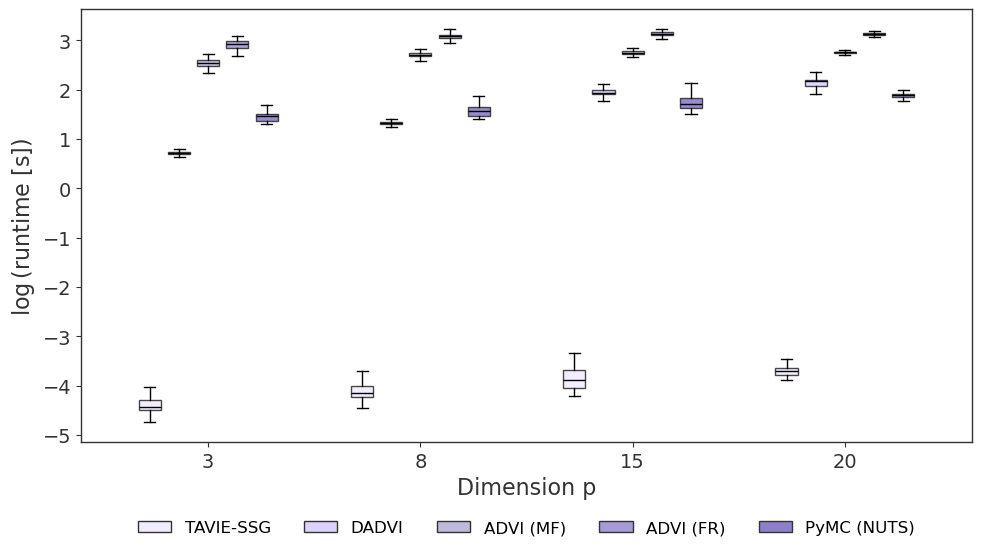

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# 6-step lavender–purple gradient centered on #BEBADA
colors_runtime = [
    '#f2ecff',  # very light lilac
    '#ddd1ff',  # soft lavender
    '#bebada',  # pastel purple (anchor tone)
    '#a89ad6',  # deeper lavender
    '#8f7ec9',  # bluish purple
    '#715fb3',  # dark violet
]

# colors_runtime = [
#     '#fee5d9',  # light rose
#     '#fcae91',  # warm peach
#     '#fb6a4a',  # vivid coral
#     '#ef3b2c',  # bright scarlet
#     '#cb181d',  # deep red
#     '#a01520'   # balanced crimson (less maroon, cleaner finish)
# ]

runtime_arrays_p = [
    time_TAVIE, time_DADVI,
    time_ADVI_mf, time_ADVI_fr, time_NUTS
]

p_sizes = len(p_values)
M = len(methods)
group_spacing = 2.4
method_step = 0.33
box_width = 0.25
centers = np.arange(p_sizes) * group_spacing

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.0)

# ----- Boxplots only -----
for j, arr in enumerate(runtime_arrays_p):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )

    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

# ----- Axes styling -----
ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=14)
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=16, color='#333333')
#ax.set_title('Log-runtime by method', fontsize=16, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
#ax.grid(True, linestyle='--', color='#BBBBBB', alpha=0.6)

# ----- Legend -----
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
ax.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
          fontsize=12, bbox_to_anchor=(0.5, -0.25))

plt.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig('results_compete/plots/runtime_logscale_lavender_boxplotonly.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


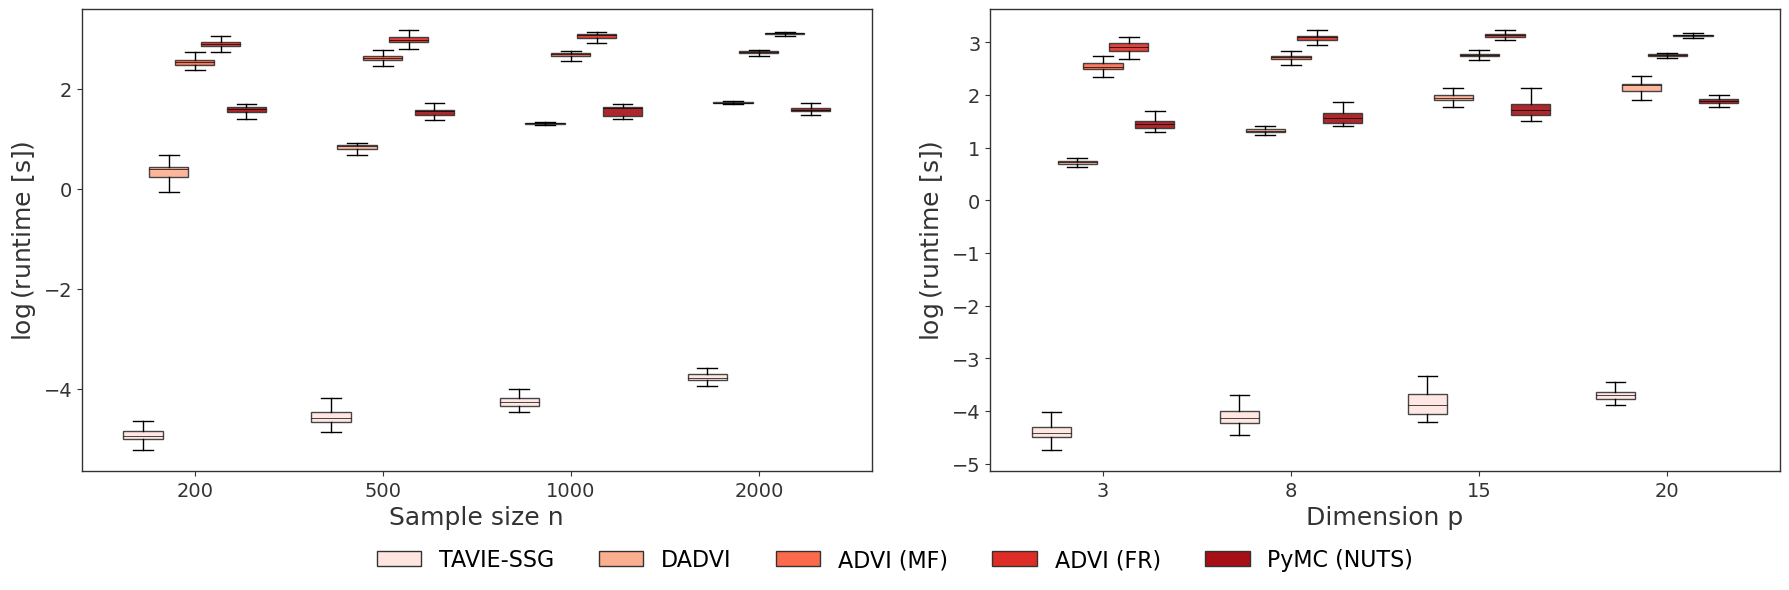

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# lavender–purple gradient centered on #BEBADA
# colors_runtime = [
#     '#f2ecff',  # very light lilac
#     '#ddd1ff',  # soft lavender
#     '#bebada',  # pastel purple (anchor tone)
#     '#a89ad6',  # deeper lavender
#     '#8f7ec9',  # bluish purple
# ]

# colors_runtime= [
#     '#c7e9f1',  # pale aqua
#     '#63a8d3',  # sky blue
#     '#2171b5',  # cobalt
#     '#6a51a3',  # indigo-violet
#     '#54278f'   # deep violet
# ]

colors_runtime = [
    '#ffe5e0',  # light peach-rose
    '#fcae91',  # coral
    '#fb6a4a',  # bright red-orange
    '#de2d26',  # scarlet red
    '#a50f15'   # rich crimson
]


# ----- Data arrays -----
#runtime_arrays_n = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
#runtime_arrays_p = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]

n_sizes = len(sample_sizes)
p_sizes = len(p_values)
M = len(methods)
group_spacing = 2.4
method_step = 0.33
box_width = 0.50#0.25

# --- Create 1x2 figure ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=0.5)

# ===============================================================
# Left panel: runtime vs sample size n
# ===============================================================
ax = axes[0]
centers = np.arange(n_sizes) * group_spacing

for j, arr in enumerate(runtime_arrays_n):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data, positions=positions, widths=box_width, patch_artist=True,
        medianprops=median_kws, showfliers=False,
        whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=15)
ax.set_xlabel('Sample size n', fontsize=18, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=18, color='#333333')
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
for spine in ax.spines.values():
    spine.set_color('#333333'); spine.set_linewidth(1.0)

# ===============================================================
# Right panel: runtime vs dimension p
# ===============================================================
ax = axes[1]
centers = np.arange(p_sizes) * group_spacing

for j, arr in enumerate(runtime_arrays_p):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data, positions=positions, widths=box_width, patch_artist=True,
        medianprops=median_kws, showfliers=False,
        whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=15)
ax.set_xlabel('Dimension p', fontsize=18, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=18, color='#333333')
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
for spine in ax.spines.values():
    spine.set_color('#333333'); spine.set_linewidth(1.0)

# ===============================================================
# Common legend (below both panels)
# ===============================================================
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
           fontsize=16, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.subplots_adjust(wspace=0.15, bottom=0.15, top=0.92)

fig.savefig('results_compete/plots/runtime_Laplace_multi_n_multi_p.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## Reading the results for Student's-t

### Student's-t SSG: TAVIE, MFVI, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000, p=5)

In [113]:
n = 1000
p = 5
path1 = f'results_compete/Student_metrics_n_{n}_p_{p}.pkl'

metrics_df_1 = pd.read_pickle(path1)

mse_beta_TAVIE = metrics_df_1['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_1['mse_tau2_TAVIE']
time_TAVIE = metrics_df_1['time_TAVIE']

mse_beta_MFVI = metrics_df_1['mse_beta_MFVI']
mse_tau2_MFVI = metrics_df_1['mse_tau2_MFVI']
time_MFVI = metrics_df_1['time_MFVI']

mse_beta_DADVI = metrics_df_1['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_1['mse_tau2_DADVI']
time_DADVI = metrics_df_1['time_DADVI']

mse_beta_ADVI_mf = metrics_df_1['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_1['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_1['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_1['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_1['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_1['time_ADVI_fr']

mse_beta_NUTS = metrics_df_1['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_1['mse_tau2_NUTS']
time_NUTS = metrics_df_1['time_NUTS']

# avg_metrics = {
#     "TAVIE": {r"MSE of $\beta$": mse_beta_TAVIE, r"MSE of $\tau^2$": mse_tau2_TAVIE, "run-time": time_TAVIE},
#     "MFVI": {r"MSE of $\beta$": mse_beta_MFVI, r"MSE of $\tau^2$": mse_tau2_MFVI, "run-time": time_MFVI},
#     "DADVI": {r"MSE of $\beta$": mse_beta_DADVI, r"MSE of $\tau^2$": mse_tau2_DADVI, "run-time": time_DADVI},
#     "ADVI MF": {r"MSE of $\beta$": mse_beta_ADVI_mf, r"MSE of $\tau^2$": mse_tau2_ADVI_mf, "run-time": time_ADVI_mf},
#     "ADVI FR": {r"MSE of $\beta$": mse_beta_ADVI_fr, r"MSE of $\tau^2$": mse_tau2_ADVI_fr, "run-time": time_ADVI_fr},
#     "NUTS": {r"MSE of $\beta$": mse_beta_NUTS, r"MSE of $\tau^2$": mse_tau2_NUTS, "run-time": time_NUTS},
# }

# avg = {
#     method: {
#         k: float(np.mean(np.asarray(v)))   # robust to list/Series/ndarray
#         for k, v in vals.items()
#     }
#     for method, vals in avg_metrics.items()
# }

# print(f"Average metrics for Student's-t SSG with (n,p)=({n},{p})")
# avg_df = pd.DataFrame(avg).T  # rows=methods, cols=mse_beta/mse_tau2/time
# abs_dev = deviation_tables(avg_metrics)
# format_pm(avg_df, abs_dev)

# 1) Build summary (exactly one setting)
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE($\beta$)", r"MSE($\tau^2$)", "Time (s)"]
methods = ["TAVIE", "MFVI", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "MFVI", "DADVI", "ADVI MF", "ADVI FR", "NUTS"]
settings = [1000]  # single setting only

summary = metrics_summary_single_setting(metrics_df_1, metrics, methods, settings)

# 2) HTML table in Jupyter
df_html = build_html_table_single_setting(summary, metrics, metric_display, methods, method_display)

# 3) LaTeX longtable code
latex_code = to_latex_single_setting(
    summary, metrics, metric_display, methods, method_display,
    caption="Results by method at (n,p) = (1000, 5)",
    label="tab:single-setting"
)
# print(latex_code)

FileNotFoundError: [Errno 2] No such file or directory: 'results_compete/Student_metrics_n_1000_p_5.pkl'

### Student's-t SSG: TAVIE, MFVI, DADVI, ADVI MF, ADVI FR, and NUTS (n=[200,500,1000,2000]; p=5)

In [114]:
p = 8  # <-- set this to whatever you used
path2 = f"results_compete/Student_metrics_multi_n_p_{p}.pkl"

metrics_df_2 = pd.read_pickle(path2)
sample_sizes = metrics_df_2['n']

mse_beta_TAVIE = metrics_df_2['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_2['mse_tau2_TAVIE']
time_TAVIE = metrics_df_2['time_TAVIE']

mse_beta_MFVI = metrics_df_2['mse_beta_MFVI']
mse_tau2_MFVI = metrics_df_2['mse_tau2_MFVI']
time_MFVI = metrics_df_2['time_MFVI']

mse_beta_DADVI = metrics_df_2['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_2['mse_tau2_DADVI']
time_DADVI = metrics_df_2['time_DADVI']

mse_beta_ADVI_mf = metrics_df_2['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_2['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_2['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_2['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_2['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_2['time_ADVI_fr']

mse_beta_NUTS = metrics_df_2['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_2['mse_tau2_NUTS']
time_NUTS = metrics_df_2['time_NUTS']

methods = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [5]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_2
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "MFVI", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "MFVI", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [200, 500, 1000, 2000]
settings_name = "Sample Size (n)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Student's-$t$ SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccc}
\caption{Average metrics (mean over repetitions; range below) for Student's-$t$ SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{4}{c}{Sample Size (n)} \\
\cmidrule(lr){3-6}
Metric & Method & 200 & 500 & 1000 & 2000 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{4}{c}{Sample Size (n)} \\
\cmidrule(lr){3-6}
Metric & Method & 200 & 500 & 1000 & 2000 \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{6}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{2.458e-03\\(2.372e-03, 2.544e-03)} & \makecell[c]{7.453e-04\\(5.901e-04, 9.006e-04)} & \makecell[c]{3.864e-04\\(3.638e-04, 4.091e-04)} & \makecell[c]{4.491e-04\\(3.818e-04, 5.163e-04)} \\
 & MFVI & \makecell[c]{2.302e-03\\(2.183e-03, 2.422e-03)} & \makecell[c]{7.094e-04\\(5.559e-04, 8.628e-04)} & \makecell[c]{3.

# Plotting for Student's-t: multi-n and single-p setting

In [51]:
# # plotting the results for TAVIE, DADVI, ADVI, and NUTS over the choice of different sample sizes n

# methods  = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
# colors   = ['C0',    'C1',    'C2',      'C3',      'C4',     'C5']
# n_sizes  = len(sample_sizes)

# # --- spacing controls ---
# M             = len(methods)
# group_spacing = 2.5    # gap between n-groups on the x-axis (↑ for bigger gaps)
# method_step   = 0.35   # separation between methods within each group
# box_width     = 0.3    # visual width of each box
# centers       = np.arange(n_sizes) * group_spacing  # group centers for each n

# fig, axes = plt.subplots(1, 2, figsize=(20, 6), facecolor='white')
# median_kws = dict(color='black', linewidth=1.5)

# # Configure axes background, spines, ticks, and grid
# for ax in axes:
#     ax.set_facecolor('white')
#     for spine in ax.spines.values():
#         spine.set_color('black'); spine.set_linewidth(1.0)
#     ax.tick_params(axis='both', colors='black', labelsize=12)
#     ax.grid(True, color='black', linestyle='--', alpha=0.5)

# # 1) τ² MSE (log scale)
# ax = axes[0]
# for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
#     data = [arr[i, :] for i in range(n_sizes)]
#     positions = centers + (j - (M-1)/2) * method_step
#     bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
#     for box in bp['boxes']:
#         box.set(facecolor=colors[j], edgecolor='black')
# ax.set_xticks(centers)
# ax.set_xticklabels(sample_sizes)
# ax.set_yscale('log')
# ax.set_xlabel('Sample size n', fontsize=12, color='black')
# ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=12, color='black')
# ax.set_title(r'$\tau^2$ MSE by method (log scale)', fontsize=14, color='black')
# ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# # 2) β MSE (log scale)
# ax = axes[1]
# for j, arr in enumerate([mse_beta_TAVIE, mse_beta_MFVI, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
#     data = [arr[i, :] for i in range(n_sizes)]
#     positions = centers + (j - (M-1)/2) * method_step
#     bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
#     for box in bp['boxes']:
#         box.set(facecolor=colors[j], edgecolor='black')
# ax.set_xticks(centers)
# ax.set_xticklabels(sample_sizes)
# ax.set_yscale('log')
# ax.set_xlabel('Sample size n', fontsize=12, color='black')
# ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12, color='black')
# ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14, color='black')
# ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# # Common legend below
# handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
# fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

# plt.tight_layout(rect=[0, 0.05, 1, 1])
# #fig.savefig(f'results_compete/plots/Laplace_metrics_multi_n_p_{p}_better.png', dpi=300, bbox_inches='tight')
# plt.show()

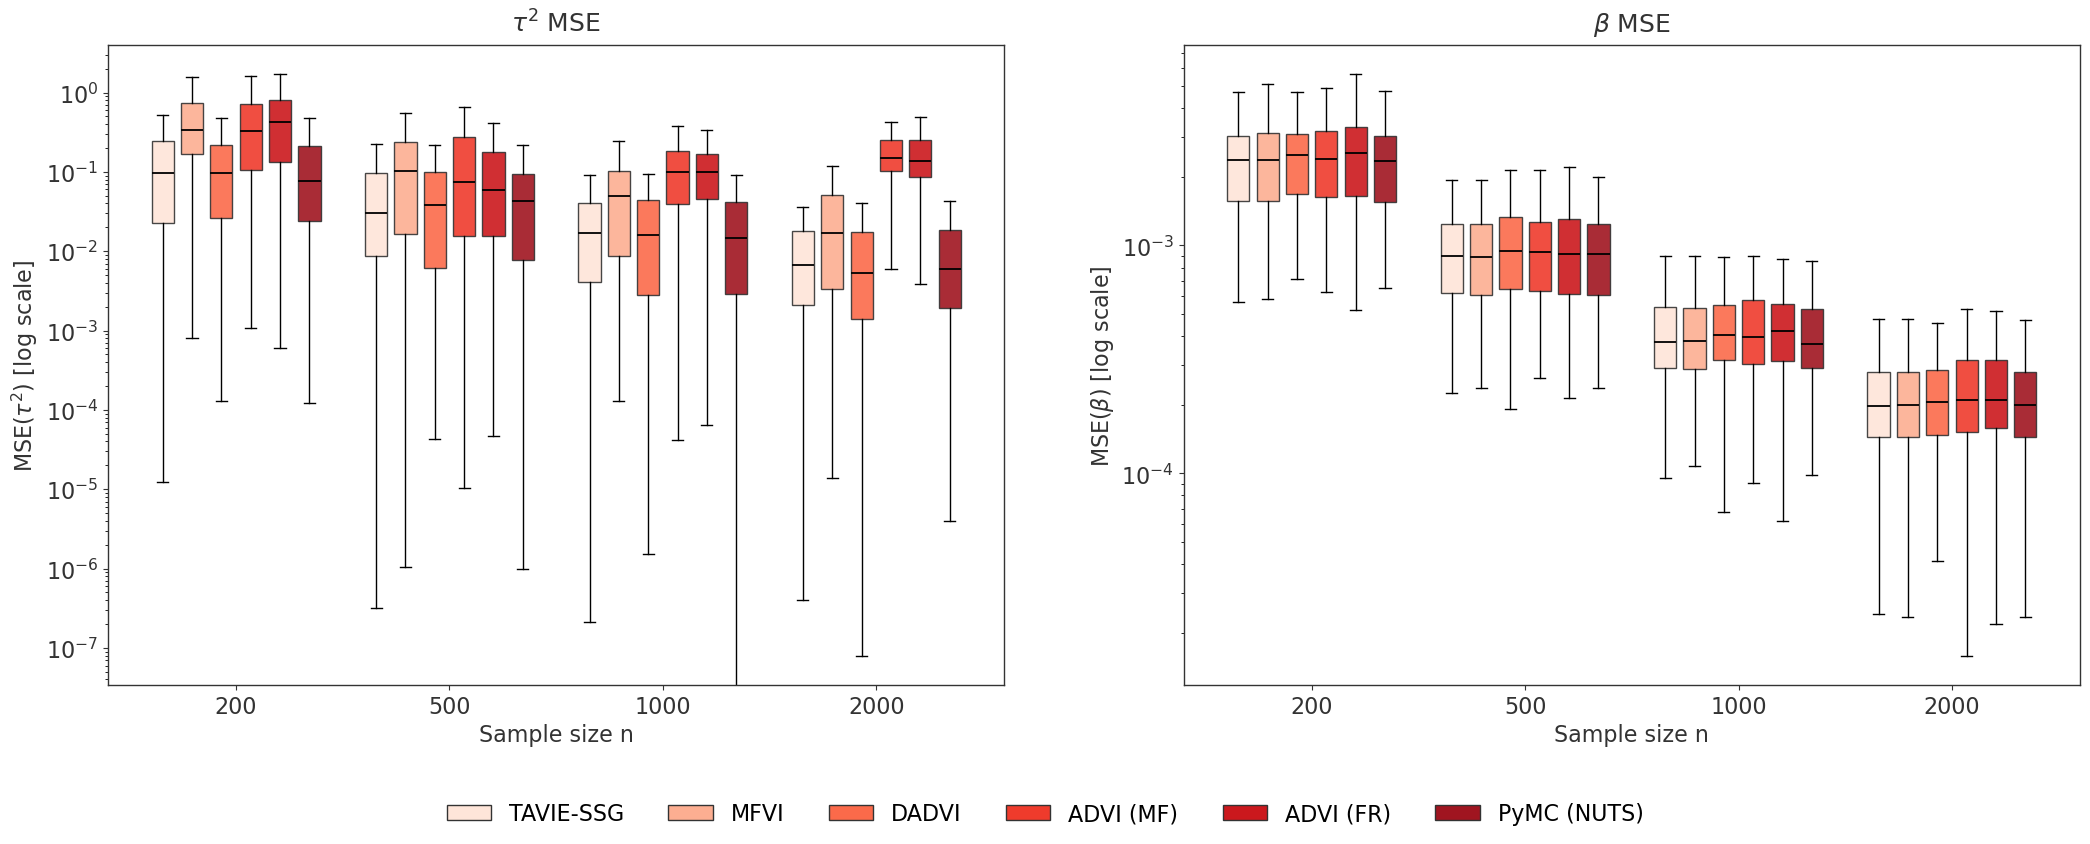

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

methods  = ['TAVIE-SSG', 'MFVI', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# nicer palette (see below for more options)
#colors   = ['#355C7D', '#F67280', '#99B898', '#C06C84', '#F8B195', '#6C5B7B']
# colors = [
#     '#fde0dd',  # light rose
#     '#fcbba1',  # salmon pink
#     '#fc9272',  # soft coral
#     '#fb6a4a',  # reddish coral
#     '#de2d26',  # crimson red
#     '#a50f15'   # deep maroon
# ]
colors = [
    '#fee5d9',  # light rose
    '#fcae91',  # warm peach
    '#fb6a4a',  # vivid coral
    '#ef3b2c',  # bright scarlet
    '#cb181d',  # deep red
    '#a01520'   # balanced crimson (less maroon, cleaner finish)
]




n_sizes  = len(sample_sizes)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between n-groups on the x-axis
method_step   = 0.33    # separation between methods within each group
box_width     = 0.25    # visual width of each box
centers       = np.arange(n_sizes) * group_spacing  # group centers for each n

fig, axes = plt.subplots(1, 2, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# global style for axes
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='#333333', labelsize=16)
    #ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- 1) τ² MSE (log scale) ----------
ax = axes[0]
tau2_arrays = [
    mse_tau2_TAVIE,
    mse_tau2_MFVI,
    mse_tau2_DADVI,
    mse_tau2_ADVI_mf,
    mse_tau2_ADVI_fr,
    mse_tau2_NUTS,
]

for j, arr in enumerate(tau2_arrays):
    # data for each n: arr[i, :] is the vector of replications
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,           # often cleaner on log-scale
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\tau^2$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- 2) β MSE (log scale) ----------
ax = axes[1]
beta_arrays = [
    mse_beta_TAVIE,
    mse_beta_MFVI,
    mse_beta_DADVI,
    mse_beta_ADVI_mf,
    mse_beta_ADVI_fr,
    mse_beta_NUTS,
]

for j, arr in enumerate(beta_arrays):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])

plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)
fig.savefig(
    f'results_compete/plots/Student_MSE_boxplots_multi_n_p_{p}.png',  # choose your preferred path/name
    dpi=300,
    bbox_inches='tight',   # ensures no clipping of labels/legend
    facecolor='white'      # preserves clean white background
)
plt.show()


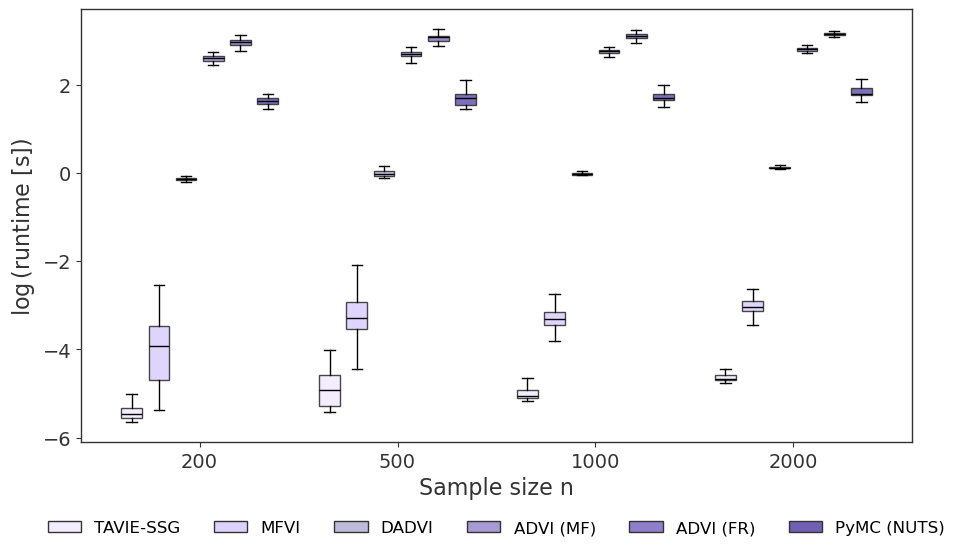

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'MFVI', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# 6-step lavender–purple gradient centered on #BEBADA
colors_runtime = [
    '#f2ecff',  # very light lilac
    '#ddd1ff',  # soft lavender
    '#bebada',  # pastel purple (anchor tone)
    '#a89ad6',  # deeper lavender
    '#8f7ec9',  # bluish purple
    '#715fb3',  # dark violet
]

# colors_runtime = [
#     '#fee5d9',  # light rose
#     '#fcae91',  # warm peach
#     '#fb6a4a',  # vivid coral
#     '#ef3b2c',  # bright scarlet
#     '#cb181d',  # deep red
#     '#a01520'   # balanced crimson (less maroon, cleaner finish)
# ]

runtime_arrays_n = [
    time_TAVIE, time_MFVI, time_DADVI,
    time_ADVI_mf, time_ADVI_fr, time_NUTS
]

n_sizes = len(sample_sizes)
M = len(methods)
group_spacing = 2.4
method_step = 0.33
box_width = 0.25
centers = np.arange(n_sizes) * group_spacing

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.0)

# ----- Boxplots only -----
for j, arr in enumerate(runtime_arrays_n):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )

    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

# ----- Axes styling -----
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=14)
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=16, color='#333333')
#ax.set_title('Log-runtime by method', fontsize=16, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
#ax.grid(True, linestyle='--', color='#BBBBBB', alpha=0.6)

# ----- Legend -----
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
ax.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
          fontsize=12, bbox_to_anchor=(0.5, -0.25))

plt.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig('results_compete/plots/runtime_logscale_lavender_boxplotonly.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [116]:
n = 1000
path3 = f'results_compete/Student_metrics_multi_p_n_{n}.pkl'

metrics_df_3 = pd.read_pickle(path3)
p_values = metrics_df_3['p']

mse_beta_TAVIE = metrics_df_3['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_3['mse_tau2_TAVIE']
time_TAVIE = metrics_df_3['time_TAVIE']

mse_beta_MFVI = metrics_df_3['mse_beta_MFVI']
mse_tau2_MFVI = metrics_df_3['mse_tau2_MFVI']
time_MFVI = metrics_df_3['time_MFVI']

mse_beta_DADVI = metrics_df_3['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_3['mse_tau2_DADVI']
time_DADVI = metrics_df_3['time_DADVI']

mse_beta_ADVI_mf = metrics_df_3['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_3['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_3['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_3['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_3['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_3['time_ADVI_fr']

mse_beta_NUTS = metrics_df_3['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_3['mse_tau2_NUTS']
time_NUTS = metrics_df_3['time_NUTS']

methods = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [53]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_3
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "MFVI", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "MFVI", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [3,4,5,6]
settings_name = "Dimension (p)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Student's-$t$ SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccc}
\caption{Average metrics (mean over repetitions; range below) for Student's-$t$ SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{4}{c}{Dimension (p)} \\
\cmidrule(lr){3-6}
Metric & Method & 3 & 4 & 5 & 6 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{4}{c}{Dimension (p)} \\
\cmidrule(lr){3-6}
Metric & Method & 3 & 4 & 5 & 6 \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{6}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{3.244e-04\\(1.775e-04, 5.976e-04)} & \makecell[c]{3.774e-04\\(2.872e-04, 5.312e-04)} & \makecell[c]{4.204e-04\\(3.300e-04, 5.421e-04)} & \makecell[c]{4.721e-04\\(3.779e-04, 5.649e-04)} \\
 & MFVI & \makecell[c]{3.341e-04\\(1.781e-04, 6.078e-04)} & \makecell[c]{3.833e-04\\(2.943e-04, 5.331e-04)} & \makecell[c]{4.147e-04\\(3.306e-04, 5.6

# Plotting for Student's-t: multi-p and single-n setting

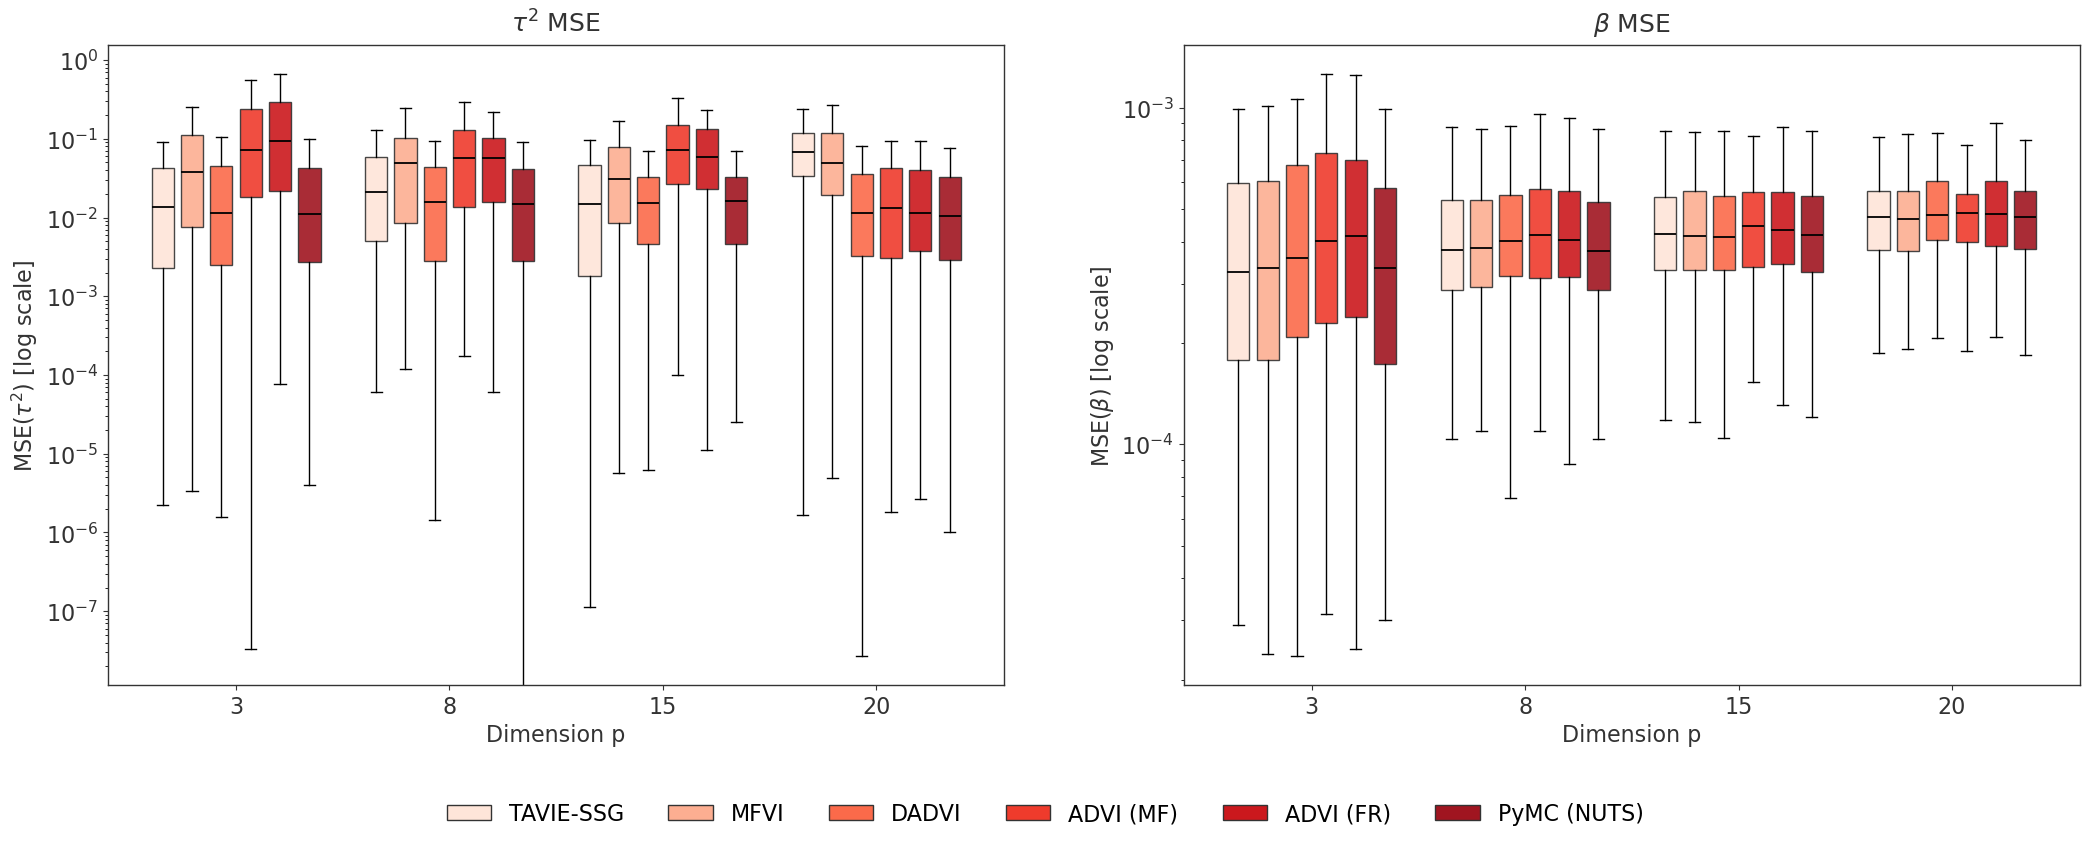

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

methods  = ['TAVIE-SSG', 'MFVI', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# nicer palette (see below for more options)
#colors   = ['#355C7D', '#F67280', '#99B898', '#C06C84', '#F8B195', '#6C5B7B']
# colors = [
#     '#fde0dd',  # light rose
#     '#fcbba1',  # salmon pink
#     '#fc9272',  # soft coral
#     '#fb6a4a',  # reddish coral
#     '#de2d26',  # crimson red
#     '#a50f15'   # deep maroon
# ]
colors = [
    '#fee5d9',  # light rose
    '#fcae91',  # warm peach
    '#fb6a4a',  # vivid coral
    '#ef3b2c',  # bright scarlet
    '#cb181d',  # deep red
    '#a01520'   # balanced crimson (less maroon, cleaner finish)
]




p_sizes  = len(p_values)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between n-groups on the x-axis
method_step   = 0.33    # separation between methods within each group
box_width     = 0.25    # visual width of each box
centers       = np.arange(p_sizes) * group_spacing  # group centers for each n

fig, axes = plt.subplots(1, 2, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# global style for axes
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='#333333', labelsize=16)
    #ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- 1) τ² MSE (log scale) ----------
ax = axes[0]
tau2_arrays = [
    mse_tau2_TAVIE,
    mse_tau2_MFVI,
    mse_tau2_DADVI,
    mse_tau2_ADVI_mf,
    mse_tau2_ADVI_fr,
    mse_tau2_NUTS,
]

for j, arr in enumerate(tau2_arrays):
    # data for each n: arr[i, :] is the vector of replications
    data = [arr[i, :] for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,           # often cleaner on log-scale
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\tau^2$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- 2) β MSE (log scale) ----------
ax = axes[1]
beta_arrays = [
    mse_beta_TAVIE,
    mse_beta_MFVI,
    mse_beta_DADVI,
    mse_beta_ADVI_mf,
    mse_beta_ADVI_fr,
    mse_beta_NUTS,
]

for j, arr in enumerate(beta_arrays):
    data = [arr[i, :] for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])

plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)
fig.savefig(
    f'results_compete/plots/Student_MSE_boxplots_multi_p_n_{n}.png',  # choose your preferred path/name
    dpi=300,
    bbox_inches='tight',   # ensures no clipping of labels/legend
    facecolor='white'      # preserves clean white background
)
plt.show()


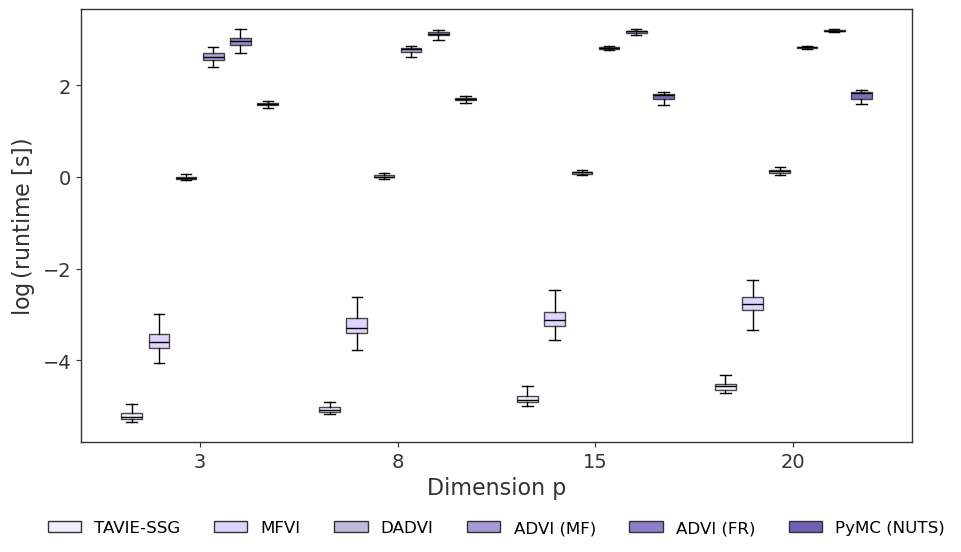

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'MFVI', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# 6-step lavender–purple gradient centered on #BEBADA
colors_runtime = [
    '#f2ecff',  # very light lilac
    '#ddd1ff',  # soft lavender
    '#bebada',  # pastel purple (anchor tone)
    '#a89ad6',  # deeper lavender
    '#8f7ec9',  # bluish purple
    '#715fb3',  # dark violet
]

# colors_runtime = [
#     '#fee5d9',  # light rose
#     '#fcae91',  # warm peach
#     '#fb6a4a',  # vivid coral
#     '#ef3b2c',  # bright scarlet
#     '#cb181d',  # deep red
#     '#a01520'   # balanced crimson (less maroon, cleaner finish)
# ]

runtime_arrays_p = [
    time_TAVIE, time_MFVI, time_DADVI,
    time_ADVI_mf, time_ADVI_fr, time_NUTS
]

p_sizes = len(p_values)
M = len(methods)
group_spacing = 2.4
method_step = 0.33
box_width = 0.25
centers = np.arange(p_sizes) * group_spacing

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.0)

# ----- Boxplots only -----
for j, arr in enumerate(runtime_arrays_p):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )

    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

# ----- Axes styling -----
ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=14)
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=16, color='#333333')
#ax.set_title('Log-runtime by method', fontsize=16, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
#ax.grid(True, linestyle='--', color='#BBBBBB', alpha=0.6)

# ----- Legend -----
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
ax.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
          fontsize=12, bbox_to_anchor=(0.5, -0.25))

plt.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig('results_compete/plots/runtime_logscale_lavender_boxplotonly.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


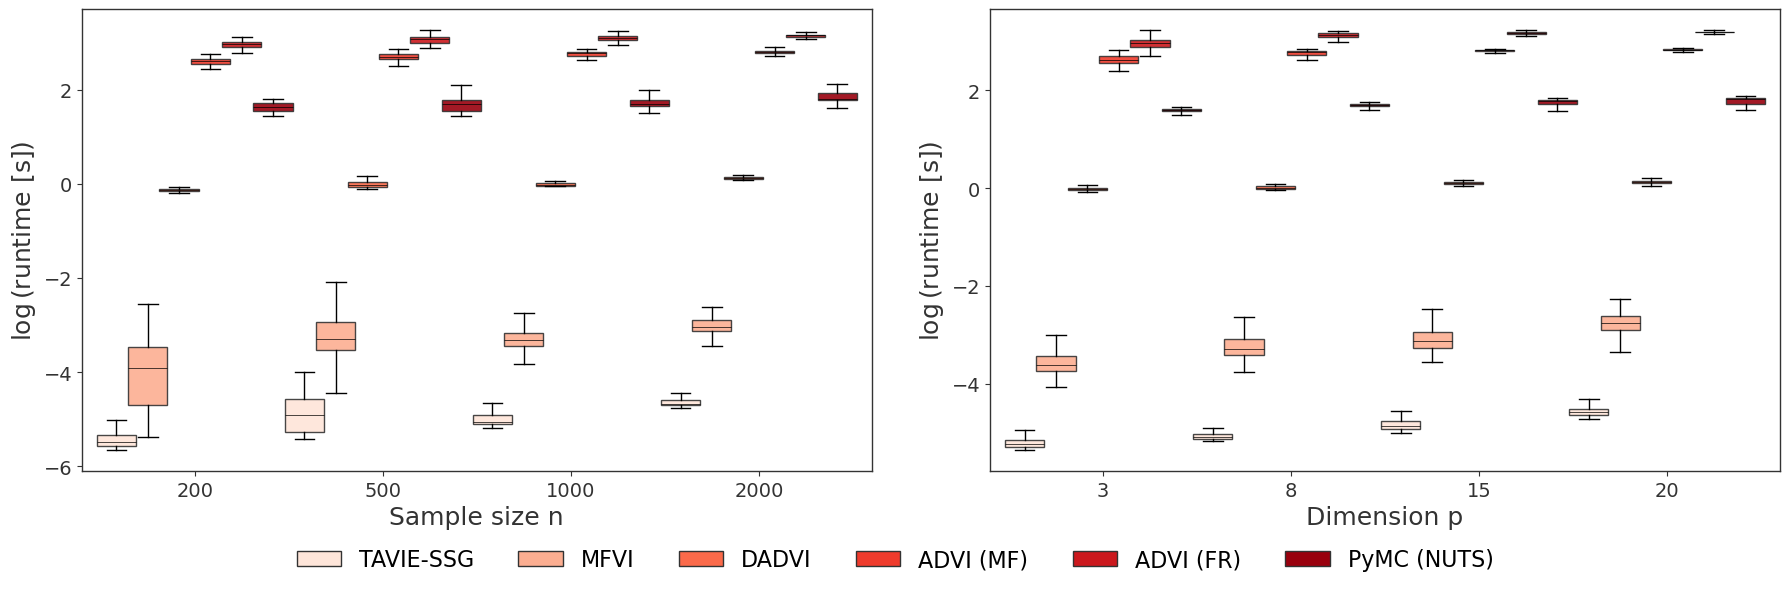

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'MFVI', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# lavender–purple gradient centered on #BEBADA
# colors_runtime = [
#     '#f2ecff',  # very light lilac
#     '#ddd1ff',  # soft lavender
#     '#bebada',  # pastel purple (anchor tone)
#     '#a89ad6',  # deeper lavender
#     '#8f7ec9',  # bluish purple
# ]

# colors_runtime= [
#     '#c7e9f1',  # pale aqua
#     '#63a8d3',  # sky blue
#     '#2171b5',  # cobalt
#     '#6a51a3',  # indigo-violet
#     '#54278f'   # deep violet
# ]

# colors_runtime = [
#     '#ffe5e0',  # light peach-rose
#     '#fcae91',  # coral
#     '#fb6a4a',  # bright red-orange
#     '#de2d26',  # scarlet red
#     '#a50f15'   # rich crimson
# ]

colors_runtime = [
    '#fee5d9',  # NEW very light rose  ← added
    '#fcae91',  # coral
    '#fb6a4a',  # bright red-orange
    '#ef3b2c',  # vivid scarlet (replaces de2d26)
    '#cb181d',  # crimson red
    '#99000d'   # deep wine-red
]


# ----- Data arrays -----
#runtime_arrays_n = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
#runtime_arrays_p = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]

n_sizes = len(sample_sizes)
p_sizes = len(p_values)
M = len(methods)
group_spacing = 2.4
method_step = 0.40#0.33
box_width = 0.50#0.25

# --- Create 1x2 figure ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=0.5)

# ===============================================================
# Left panel: runtime vs sample size n
# ===============================================================
ax = axes[0]
centers = np.arange(n_sizes) * group_spacing

for j, arr in enumerate(runtime_arrays_n):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data, positions=positions, widths=box_width, patch_artist=True,
        medianprops=median_kws, showfliers=False,
        whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=15)
ax.set_xlabel('Sample size n', fontsize=18, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=18, color='#333333')
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
for spine in ax.spines.values():
    spine.set_color('#333333'); spine.set_linewidth(1.0)

# ===============================================================
# Right panel: runtime vs dimension p
# ===============================================================
ax = axes[1]
centers = np.arange(p_sizes) * group_spacing

for j, arr in enumerate(runtime_arrays_p):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data, positions=positions, widths=box_width, patch_artist=True,
        medianprops=median_kws, showfliers=False,
        whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=15)
ax.set_xlabel('Dimension p', fontsize=18, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=18, color='#333333')
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
for spine in ax.spines.values():
    spine.set_color('#333333'); spine.set_linewidth(1.0)

# ===============================================================
# Common legend (below both panels)
# ===============================================================
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
           fontsize=16, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.subplots_adjust(wspace=0.15, bottom=0.15, top=0.92)

fig.savefig('results_compete/plots/runtime_Student_multi_n_multi_p.png',
             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## Reading the results for Negative-Binomial

### Negative-Binomial SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000 and p=5)

In [121]:
n = 1000
p = 8
path1 = f'results_compete/NegBin_metrics_n_{n}_p_{p}.pkl'

metrics_df_1 = pd.read_pickle(path1)

mse_beta_TAVIE = metrics_df_1['mse_beta_TAVIE']
time_TAVIE = metrics_df_1['time_TAVIE']

mse_beta_DADVI = metrics_df_1['mse_beta_DADVI']
time_DADVI = metrics_df_1['time_DADVI']

mse_beta_ADVI_mf = metrics_df_1['mse_beta_ADVI_mf']
time_ADVI_mf = metrics_df_1['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_1['mse_beta_ADVI_fr']
time_ADVI_fr = metrics_df_1['time_ADVI_fr']

mse_beta_NUTS = metrics_df_1['mse_beta_NUTS']
time_NUTS = metrics_df_1['time_NUTS']

# avg_metrics = {
#     "TAVIE": {r"MSE of $\beta$": mse_beta_TAVIE, "run-time": time_TAVIE},
#     "DADVI": {r"MSE of $\beta$": mse_beta_DADVI, "run-time": time_DADVI},
#     "ADVI MF": {r"MSE of $\beta$": mse_beta_ADVI_mf, "run-time": time_ADVI_mf},
#     "ADVI FR": {r"MSE of $\beta$": mse_beta_ADVI_fr, "run-time": time_ADVI_fr},
#     "NUTS": {r"MSE of $\beta$": mse_beta_NUTS, "run-time": time_NUTS},
# }

# avg = {
#     method: {
#         k: float(np.mean(np.asarray(v)))   # robust to list/Series/ndarray
#         for k, v in vals.items()
#     }
#     for method, vals in avg_metrics.items()
# }

# print(f'Average metrics for Negative-Binomial SSG with (n,p)=({n},{p})')
# avg_df = pd.DataFrame(avg).T  # rows=methods, cols=mse_beta/mse_tau2/time
# abs_dev = deviation_tables(avg_metrics)
# format_pm(avg_df, abs_dev)

# 1) Build summary (exactly one setting)
metrics = ["mse_beta", "time"]
metric_display = [r"MSE($\beta$)", "Time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI MF", "ADVI FR", "NUTS"]
settings = [10000]  # single setting only

summary = metrics_summary_single_setting(metrics_df_1, metrics, methods, settings)

# 2) HTML table in Jupyter
df_html = build_html_table_single_setting(summary, metrics, metric_display, methods, method_display)

# 3) LaTeX longtable code
latex_code = to_latex_single_setting(
    summary, metrics, metric_display, methods, method_display,
    caption="Results by method at (n,p) = (1000, 5)",
    label="tab:single-setting"
)
print(latex_code)

FileNotFoundError: [Errno 2] No such file or directory: 'results_compete/NegBin_metrics_n_1000_p_8.pkl'

### Negative-Binomial SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=[200,500,1000,2000]; p=5)

In [136]:
p = 8  # <-- set this to whatever you used
path2 = f'results_compete/NegBin_metrics_multi_n_p_{p}.pkl'

metrics_df_2 = pd.read_pickle(path2)
sample_sizes = metrics_df_2['n']

mse_beta_TAVIE = metrics_df_2['mse_beta_TAVIE']
time_TAVIE = metrics_df_2['time_TAVIE']

mse_beta_DADVI = metrics_df_2['mse_beta_DADVI']
time_DADVI = metrics_df_2['time_DADVI']

mse_beta_ADVI_mf = metrics_df_2['mse_beta_ADVI_mf']
time_ADVI_mf = metrics_df_2['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_2['mse_beta_ADVI_fr']
time_ADVI_fr = metrics_df_2['time_ADVI_fr']

mse_beta_NUTS = metrics_df_2['mse_beta_NUTS']
time_NUTS = metrics_df_2['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

runtime_arrays_n = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]

In [123]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_2
metrics = ["mse_beta", "time"]
metric_display = [r"MSE of $\beta$",  "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [200, 500, 1000, 2000]
settings_name = "Sample Size"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Negative-Binomial SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccc}
\caption{Average metrics (mean over repetitions; range below) for Negative-Binomial SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{4}{c}{Sample Size} \\
\cmidrule(lr){3-6}
Metric & Method & 200 & 500 & 1000 & 2000 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{4}{c}{Sample Size} \\
\cmidrule(lr){3-6}
Metric & Method & 200 & 500 & 1000 & 2000 \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{5}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{1.110e-03\\(7.542e-04, 1.583e-03)} & \makecell[c]{5.028e-04\\(3.510e-04, 6.714e-04)} & \makecell[c]{2.326e-04\\(1.671e-04, 3.165e-04)} & \makecell[c]{1.279e-04\\(9.403e-05, 1.772e-04)} \\
 & DADVI & \makecell[c]{1.080e-03\\(8.092e-04, 1.690e-03)} & \makecell[c]{5.070e-04\\(3.724e-04, 6.997e-04)} & \makecell[c]{2.436

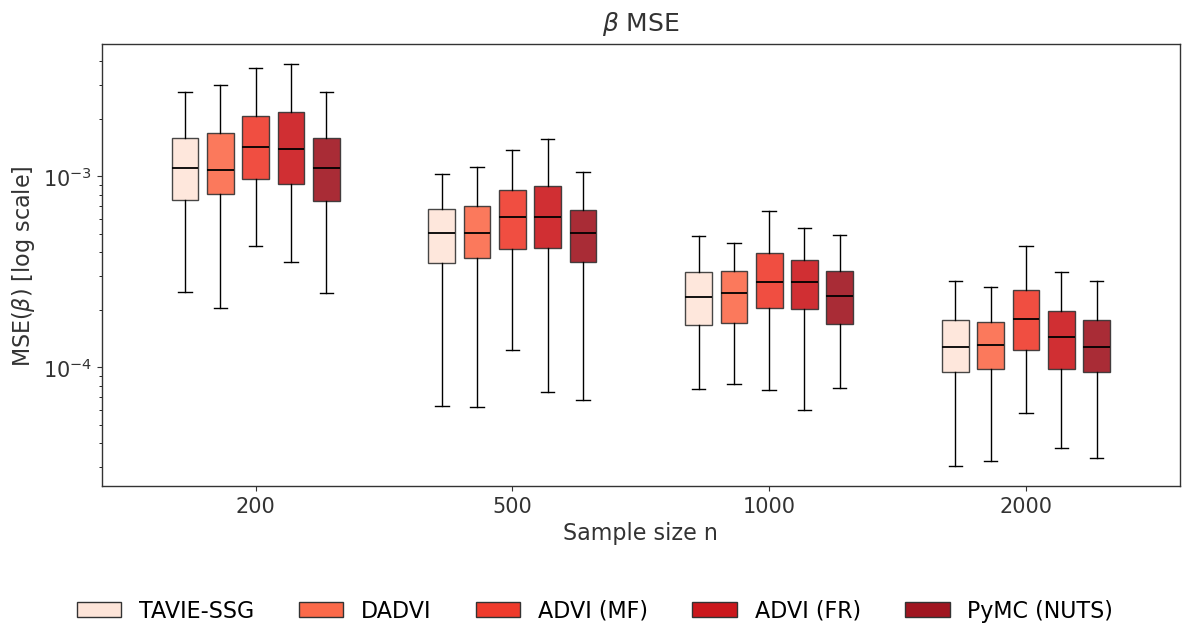

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

methods = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# 5 red-ish tones, light → deep
colors = [
    '#fee5d9',  # light rose
    '#fb6a4a',  # vivid coral
    '#ef3b2c',  # bright scarlet
    '#cb181d',  # deep red
    '#a01520',  # balanced crimson
]

n_sizes = len(sample_sizes)

# layout controls
M             = len(methods)
group_spacing = 2.4
method_step   = 0.33
box_width     = 0.25
centers       = np.arange(n_sizes) * group_spacing

fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# ---- β MSE (log scale) ----
beta_arrays = [
    mse_beta_TAVIE,
    mse_beta_DADVI,
    mse_beta_ADVI_mf,
    mse_beta_ADVI_fr,
    mse_beta_NUTS,
]

for j, arr in enumerate(beta_arrays):
    # arr shape: (n_sizes, n_reps)
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=15)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6,
            centers[-1] + group_spacing * 0.6)

# style
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=15)

# legend below
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(
    handles=handles,
    loc='lower center',
    ncol=M,
    frameon=False,
    bbox_to_anchor=(0.5, -0.08),
    fontsize=16,
)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.subplots_adjust(bottom=0.18)
fig.savefig(
    f'results_compete/plots/Neg-Bin_MSE_boxplots_multi_n_p_{p}.png',  # choose your preferred path/name
    dpi=300,
    bbox_inches='tight',   # ensures no clipping of labels/legend
    facecolor='white'      # preserves clean white background
)
plt.show()

### Negative-Binomial SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000; p=[3,4,5,6])

In [137]:
n = 1000
path3 = f'results_compete/NegBin_metrics_multi_p_n_{n}.pkl'

metrics_df_3 = pd.read_pickle(path3)
p_values = metrics_df_3['p']

mse_beta_TAVIE = metrics_df_3['mse_beta_TAVIE']
time_TAVIE = metrics_df_3['time_TAVIE']

mse_beta_DADVI = metrics_df_3['mse_beta_DADVI']
time_DADVI = metrics_df_3['time_DADVI']

mse_beta_ADVI_mf = metrics_df_3['mse_beta_ADVI_mf']
time_ADVI_mf = metrics_df_3['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_3['mse_beta_ADVI_fr']
time_ADVI_fr = metrics_df_3['time_ADVI_fr']

mse_beta_NUTS = metrics_df_3['mse_beta_NUTS']
time_NUTS = metrics_df_3['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

runtime_arrays_p = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]

In [131]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_3
metrics = ["mse_beta", "time"]
metric_display = [r"MSE of $\beta$", "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [3, 4, 5, 6]
settings_name = "Dimension (p)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Negative-Binomial SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccc}
\caption{Average metrics (mean over repetitions; range below) for Negative-Binomial SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{4}{c}{Dimension (p)} \\
\cmidrule(lr){3-6}
Metric & Method & 3 & 4 & 5 & 6 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{4}{c}{Dimension (p)} \\
\cmidrule(lr){3-6}
Metric & Method & 3 & 4 & 5 & 6 \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{5}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{1.471e-04\\(1.035e-04, 2.732e-04)} & \makecell[c]{1.652e-04\\(1.126e-04, 2.204e-04)} & \makecell[c]{1.795e-04\\(1.383e-04, 2.020e-04)} & \makecell[c]{2.415e-04\\(1.772e-04, 2.939e-04)} \\
 & DADVI & \makecell[c]{1.694e-04\\(1.094e-04, 2.756e-04)} & \makecell[c]{1.730e-04\\(1.176e-04, 2.400e-04)} & \makecell[c]{1.801e-04\\(1.458e-04

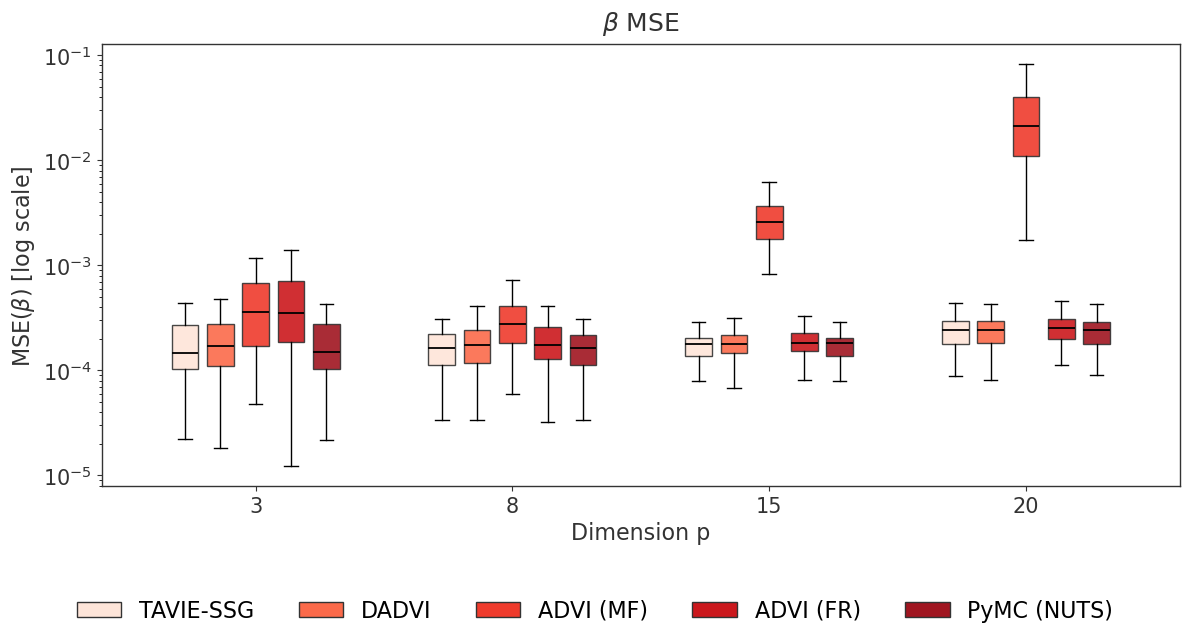

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

methods = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# 5 red-ish tones, light → deep
colors = [
    '#fee5d9',  # light rose
    '#fb6a4a',  # vivid coral
    '#ef3b2c',  # bright scarlet
    '#cb181d',  # deep red
    '#a01520',  # balanced crimson
]

p_sizes = len(p_values)

# layout controls
M             = len(methods)
group_spacing = 2.4
method_step   = 0.33
box_width     = 0.25
centers       = np.arange(p_sizes) * group_spacing

fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# ---- β MSE (log scale) ----
beta_arrays = [
    mse_beta_TAVIE,
    mse_beta_DADVI,
    mse_beta_ADVI_mf,
    mse_beta_ADVI_fr,
    mse_beta_NUTS,
]

for j, arr in enumerate(beta_arrays):
    # arr shape: (n_sizes, n_reps)
    data = [arr[i, :] for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=15)
ax.set_yscale('log')
ax.set_xlabel('Dimension p', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6,
            centers[-1] + group_spacing * 0.6)

# style
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=15)

# legend below
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(
    handles=handles,
    loc='lower center',
    ncol=M,
    frameon=False,
    bbox_to_anchor=(0.5, -0.08),
    fontsize=16,
)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.subplots_adjust(bottom=0.18)
fig.savefig(
    f'results_compete/plots/Neg-Bin_MSE_boxplots_multi_p_n_{n}.png',  # choose your preferred path/name
    dpi=300,
    bbox_inches='tight',   # ensures no clipping of labels/legend
    facecolor='white'      # preserves clean white background
)
plt.show()

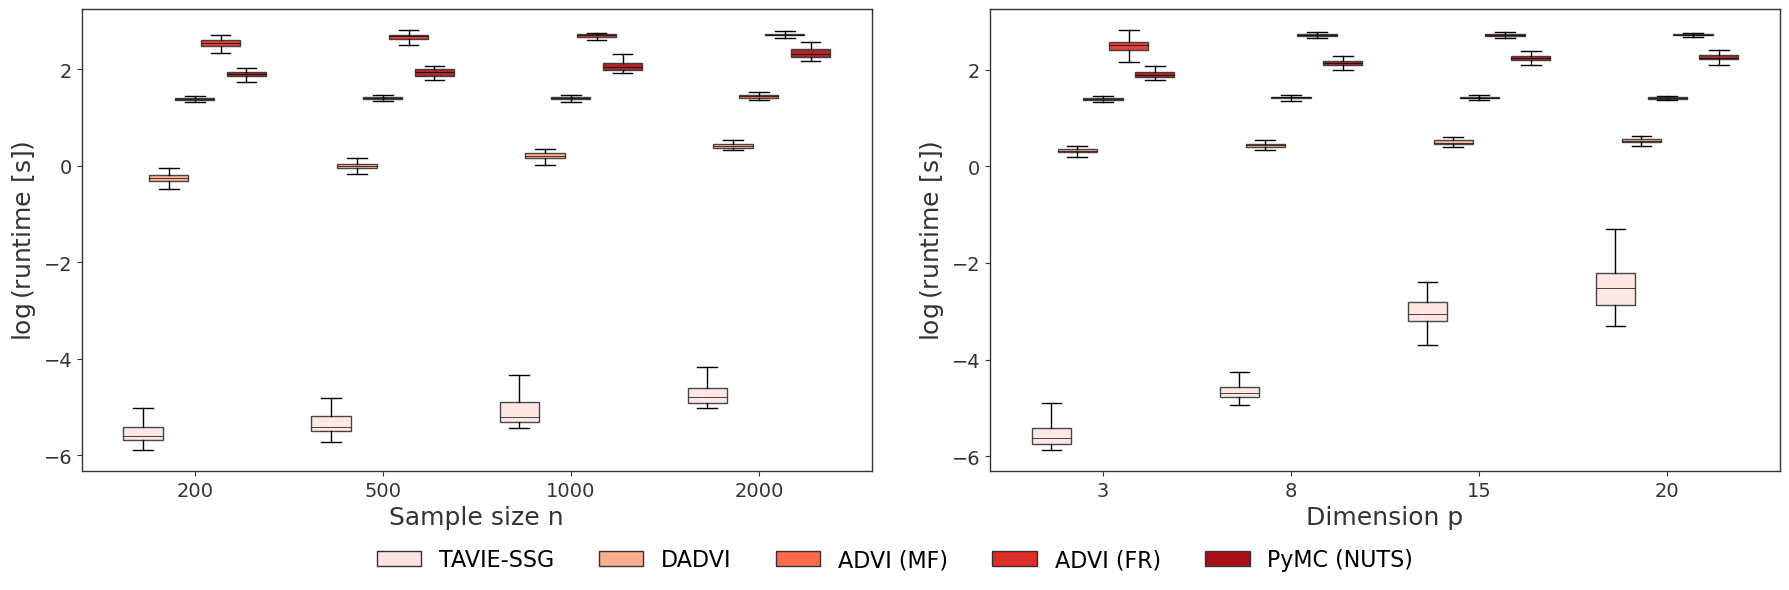

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

eps = 1e-16
methods = ['TAVIE-SSG', 'DADVI', 'ADVI (MF)', 'ADVI (FR)', 'PyMC (NUTS)']

# lavender–purple gradient centered on #BEBADA
# colors_runtime = [
#     '#f2ecff',  # very light lilac
#     '#ddd1ff',  # soft lavender
#     '#bebada',  # pastel purple (anchor tone)
#     '#a89ad6',  # deeper lavender
#     '#8f7ec9',  # bluish purple
# ]

# colors_runtime= [
#     '#c7e9f1',  # pale aqua
#     '#63a8d3',  # sky blue
#     '#2171b5',  # cobalt
#     '#6a51a3',  # indigo-violet
#     '#54278f'   # deep violet
# ]

colors_runtime = [
    '#ffe5e0',  # light peach-rose
    '#fcae91',  # coral
    '#fb6a4a',  # bright red-orange
    '#de2d26',  # scarlet red
    '#a50f15'   # rich crimson
]


# ----- Data arrays -----
#runtime_arrays_n = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
#runtime_arrays_p = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]

n_sizes = len(sample_sizes)
p_sizes = len(p_values)
M = len(methods)
group_spacing = 2.4
method_step = 0.33
box_width = 0.50#0.25

# --- Create 1x2 figure ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=0.5)

# ===============================================================
# Left panel: runtime vs sample size n
# ===============================================================
ax = axes[0]
centers = np.arange(n_sizes) * group_spacing

for j, arr in enumerate(runtime_arrays_n):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data, positions=positions, widths=box_width, patch_artist=True,
        medianprops=median_kws, showfliers=False,
        whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes, fontsize=15)
ax.set_xlabel('Sample size n', fontsize=18, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=18, color='#333333')
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
for spine in ax.spines.values():
    spine.set_color('#333333'); spine.set_linewidth(1.0)

# ===============================================================
# Right panel: runtime vs dimension p
# ===============================================================
ax = axes[1]
centers = np.arange(p_sizes) * group_spacing

for j, arr in enumerate(runtime_arrays_p):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(p_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data, positions=positions, widths=box_width, patch_artist=True,
        medianprops=median_kws, showfliers=False,
        whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors_runtime[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels(p_values, fontsize=15)
ax.set_xlabel('Dimension p', fontsize=18, color='#333333')
ax.set_ylabel(r'$\log$(runtime [s])', fontsize=18, color='#333333')
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)
ax.tick_params(axis='both', colors='#333333', labelsize=14)
for spine in ax.spines.values():
    spine.set_color('#333333'); spine.set_linewidth(1.0)

# ===============================================================
# Common legend (below both panels)
# ===============================================================
handles = [Patch(facecolor=colors_runtime[i], edgecolor='#333333', label=methods[i])
           for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False,
           fontsize=16, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.subplots_adjust(wspace=0.15, bottom=0.15, top=0.92)

fig.savefig('results_compete/plots/runtime_Negbin_multi_n_multi_p.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
